## Import modules

In [1]:
import imblearn
import pandas as pd
import seaborn as sns
import dill
import matplotlib.pyplot as plt
import numpy as np
import time


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

## Data loading

In [2]:
random_state=809
# Load data from sources
data=pd.read_csv('/Users/ignacioaranguren/Library/Mobile Documents/com~apple~CloudDocs/Imperial/modules/spring_term/big_data/Assignments/Big-Data-Project/Lending_Club_Data.csv')
# Load jupyter session
dill.load_session('/Users/ignacioaranguren/Library/Mobile Documents/com~apple~CloudDocs/Imperial/modules/spring_term/big_data/Assignments/Big-Data-Project/logistic_forest.db')
# Create test andd train
random_state = 809

## Data preprocessing

In [3]:
# Data cleaning and processing
data = data.fillna(0) # Fill na values with 0
for i in data.columns:  # Transform non-numeric types to string
    if data[i].dtypes == 'object':
        data[i] = data[i].astype('str')
# Enumerating categorical data
encoder = preprocessing.OrdinalEncoder()
encoder.fit(data)
data_encoded = encoder.transform(data)
# Dataframe creation
df = pd.DataFrame(data_encoded,columns=data.columns)
df = df.drop(["dti", "dti_joint", "emp_title", "dti_joint.1", "loan_id", "int_rate", "total_pymnt", "total_rec_int",
              "total_rec_late_fee", "total_rec_prncp", "recoveries"], axis=1)
variables = list(df.columns)
variables.remove('loan_status')
df.head(10)

,loan_status,loan_amnt,term,sub_grade,installment,issue_d,annual_inc,emp_length,verification_status,purpose,...,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,revol_bal_joint,annual_inc_joint,verification_status_joint
0,1.0,1320.0,1.0,15.0,53744.0,0.0,38792.0,3.0,2.0,2.0,...,1083.0,0.0,333044.0,352334.0,29.0,144867.0,1008.0,0.0,0.0,0.0
1,0.0,760.0,1.0,12.0,30020.0,0.0,16885.0,3.0,2.0,2.0,...,924.0,0.0,125061.0,262323.0,29.0,30574.0,875.0,0.0,0.0,0.0
2,0.0,560.0,1.0,19.0,24962.0,0.0,27275.0,1.0,0.0,2.0,...,1188.0,0.0,13020.0,3148.0,5.0,13061.0,744.0,0.0,0.0,0.0
3,0.0,408.0,0.0,10.0,23288.0,0.0,32096.0,2.0,1.0,2.0,...,713.0,0.0,89648.0,78688.0,23.0,91867.0,435.0,0.0,0.0,0.0
4,0.0,623.0,0.0,8.0,35716.0,0.0,13341.0,11.0,0.0,2.0,...,325.0,0.0,15830.0,68466.0,13.0,15871.0,4067.0,0.0,0.0,0.0
5,0.0,1160.0,1.0,18.0,50840.0,0.0,22400.0,7.0,2.0,8.0,...,455.0,0.0,9677.0,15605.0,7.0,9717.0,1424.0,0.0,0.0,0.0
6,0.0,560.0,0.0,17.0,35958.0,0.0,33120.0,0.0,0.0,10.0,...,536.0,0.0,90505.0,110099.0,21.0,92790.0,232.0,0.0,0.0,0.0
7,0.0,560.0,0.0,0.0,29280.0,0.0,29364.0,2.0,0.0,1.0,...,689.0,0.0,109098.0,113261.0,22.0,112214.0,1721.0,0.0,0.0,0.0
8,0.0,361.0,0.0,33.0,26810.0,0.0,25396.0,11.0,0.0,10.0,...,838.0,0.0,40488.0,33881.0,7.0,40537.0,477.0,0.0,0.0,0.0
9,0.0,80.0,0.0,16.0,4003.0,0.0,3618.0,4.0,2.0,9.0,...,841.0,0.0,7003.0,1999.0,11.0,7043.0,134.0,0.0,0.0,0.0


## Original dataset reduction for reduced models

In [101]:
# Randomly sample 50% of your dataframe
df_reduced = df.copy().sample(frac=0.5)
print(df.shape)
print(df_reduced.shape)

(922233, 41)
(461116, 41)


## Split data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['loan_status'], axis=1),
                                                    df['loan_status'], test_size=0.3,
                                                    random_state=random_state)

In [103]:
df = pd.DataFrame(X_train, columns = variables)
df['loan_status'] = y_train

## Split data for reduced models

In [107]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(df_reduced.drop(['loan_status'], axis=1),
                                                    df_reduced['loan_status'], test_size=0.3,
                                                    random_state=random_state)

In [108]:
df_reduced = pd.DataFrame(X_train_reduced, columns = variables)
df_reduced['loan_status'] = y_train_reduced

## Check data balancing for original and reduced dataset

### Original

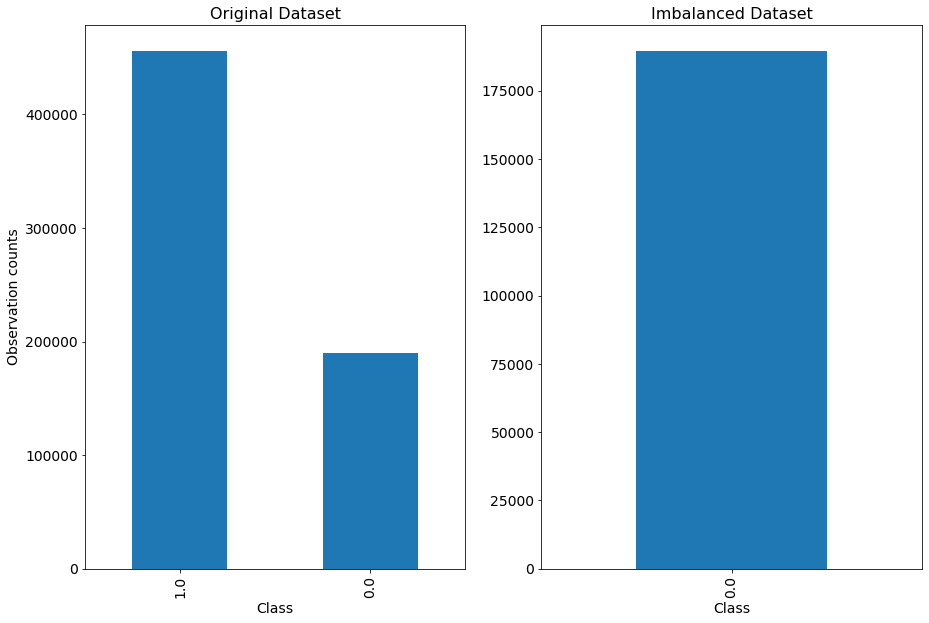

In [109]:
df_0 = df[df['loan_status']==0]
df_1 = df[df['loan_status']==1]

# Plot of the outcome variable in both datasets
fig, (ax, ax1) = plt.subplots(figsize=(15,10), ncols = 2)
df['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
df_0['loan_status'].value_counts().plot(kind='bar', ax=ax1, fontsize=14)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax.set_title('Original Dataset', fontsize=16)
ax1.set_title('Imbalanced Dataset', fontsize=16)
plt.show()

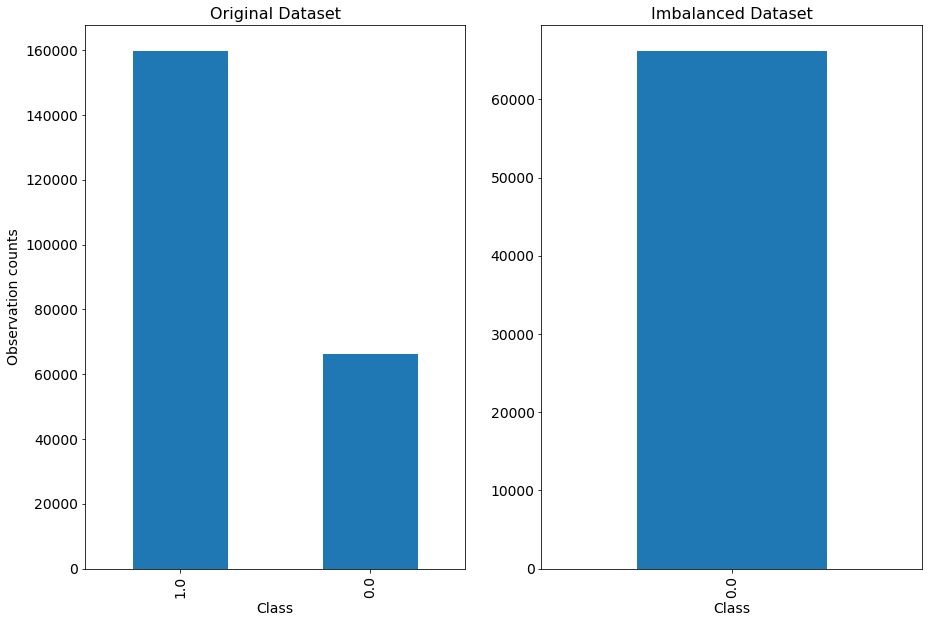

In [110]:
df_0_reduced = df_reduced[df_reduced['loan_status']==0]
df_1_reduced = df_reduced[df_reduced['loan_status']==1]

# Plot of the outcome variable in both datasets
fig, (ax, ax1) = plt.subplots(figsize=(15,10), ncols = 2)
df_reduced['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
df_0_reduced['loan_status'].value_counts().plot(kind='bar', ax=ax1, fontsize=14)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax.set_title('Original Dataset', fontsize=16)
ax1.set_title('Imbalanced Dataset', fontsize=16)
plt.show()

**Important note: In our model class 1 referes to the non-defaulters and class 0 to defaulters.**

Clearly we appreciate a significant imbalance of class 0 with respect to class 1.

Thus, we need to balance the data. In class we learned about several methods to balance imbalanced datasets.
In this case, we will use smote procedure.In the following sections we will perfomr data balancing with regular oversampling and with SMOTE oversampling.

# Logit with imbalanced data

Before performing oevesampling, let's look into the performance of the model with the original imbalanced data:

In [111]:
# Parameter optimisation
C = [1/10, 1/2, 1, 2, 10]
param_grid = {'C': C}
logit_imb = LogisticRegression(penalty="l1",
                         solver="liblinear",
                         max_iter=int(1e6),
                         warm_start=True)
cv = 3  # Cross-validation folds
cv_logit_imb = GridSearchCV(estimator=logit_imb, param_grid=param_grid, verbose=10, cv=cv, n_jobs=-1)
cv_logit_imb.fit(df_reduced[variables], df_reduced['loan_status'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000000, penalty='l1',
                                          solver='liblinear', warm_start=True),
             n_jobs=-1, param_grid={'C': [0.1, 0.5, 1, 2, 10]}, verbose=10)

### Optimal paramaters

In [112]:
optimal_logit_imb = cv_logit_imb.best_estimator_
best_parameters_logit_imb = cv_logit_imb.best_params_
print('The best Parameters are:')
for key, item in best_parameters_logit_imb.items():
    print(f'- {key}: {item}')

The best Parameters are:
- C: 10


In [113]:
print(f'Logistic score imbalanced: {optimal_logit_imb.score(X_test_reduced, y_test_reduced)}')

Logistic score imbalanced: 0.7253265864615067


### Confusion matrix

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


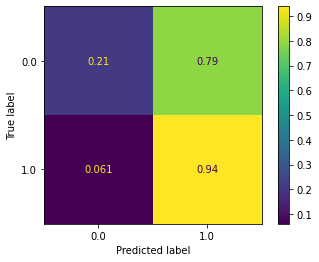

In [114]:
plot_confusion_matrix(optimal_logit_imb, X_test_reduced, y_test_reduced, normalize='true')

### Plot ROC curves

In [115]:
def plot_roc_precision(model, X_test, y_test):
    fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,10))
    plot_roc_curve(model, X_test, y_test, ax=ax)
    plot_precision_recall_curve(model, X_test, y_test, ax=ax1)
    ax.set_title('ROC', fontsize=18)
    ax1.set_title('Precision Recall', fontsize=18)
    ax.legend(fontsize=15)
    ax1.legend(fontsize=15)
    plt.suptitle('Balanced Dataset', fontsize=20)
    plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


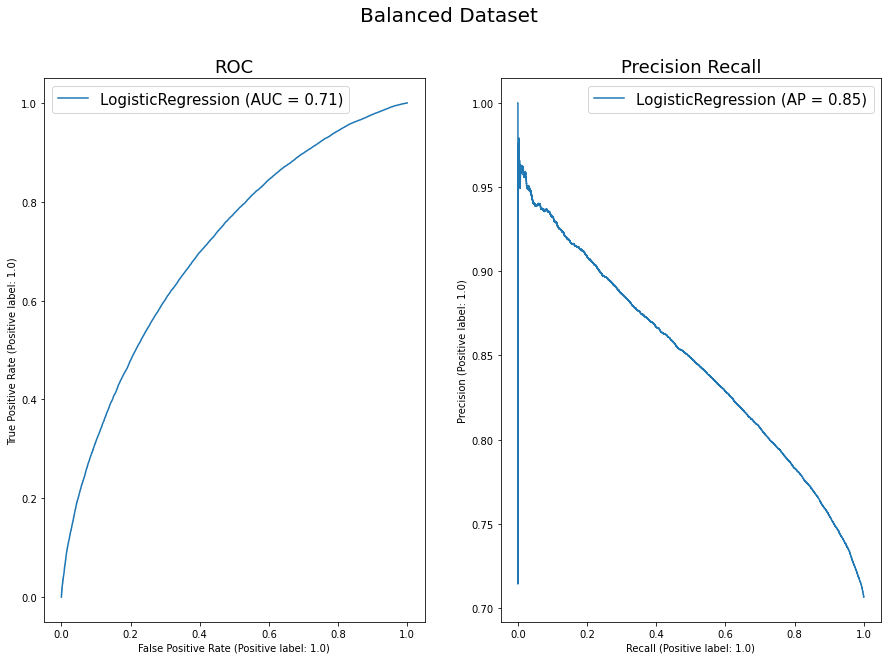

In [116]:
plot_roc_precision(optimal_logit_imb,  X_test_reduced, y_test_reduced)

The area under the curve is far from being maximized.

# Logit with ovesampled data

In [117]:
oversampler = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
oversample_x, oversample_y = oversampler.fit_resample(df_reduced[variables], df_reduced['loan_status'])
df_oversampled = pd.DataFrame(oversample_x, columns = variables)
df_oversampled['loan_status'] = oversample_y

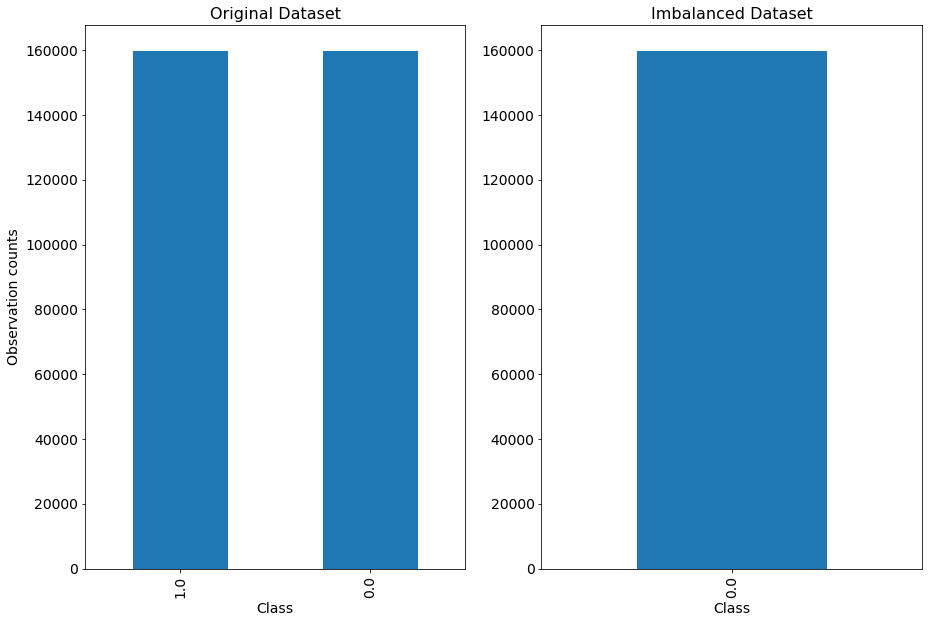

In [118]:
df_0_under = df_oversampled[df_oversampled['loan_status']==0]
df_1_under = df_oversampled[df_oversampled['loan_status']==1]

# Plot of the outcome variable in both datasets
fig, (ax, ax1) = plt.subplots(figsize=(15,10), ncols = 2)
df_oversampled['loan_status'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
df_0_under['loan_status'].value_counts().plot(kind='bar', ax=ax1, fontsize=14)
ax.set_ylabel('Observation counts', fontsize=14)
ax.set_xlabel('Class', fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax.set_title('Original Dataset', fontsize=16)
ax1.set_title('Imbalanced Dataset', fontsize=16)
plt.show()

In [119]:
# Parameter optimisation
C = [1/10, 1/2, 1, 2, 10]
param_grid = {'C': C}
logit_balanced = LogisticRegression(penalty="l1",
                         solver="liblinear",
                         max_iter=int(1e6),
                         warm_start=True)
cv = 3  # Cross-validation folds
cv_logit_balanced = GridSearchCV(estimator=logit_balanced, param_grid=param_grid, verbose=10, cv=cv, n_jobs=-1)
cv_logit_balanced.fit(df_oversampled[variables], df_oversampled['loan_status'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000000, penalty='l1',
                                          solver='liblinear', warm_start=True),
             n_jobs=-1, param_grid={'C': [0.1, 0.5, 1, 2, 10]}, verbose=10)

In [120]:
optimal_logit_balanced = cv_logit_balanced.best_estimator_
best_parameters_logit_balanced = cv_logit_balanced.best_params_
print('The best Parameters are:')
for key, item in best_parameters_logit_imb.items():
    print(f'- {key}: {item}')

The best Parameters are:
- C: 10


In [121]:
print(f'Logistic score oversampled: {optimal_logit_balanced.score(X_test, y_test)}')

Logistic score oversampled: 0.6541403115625113


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


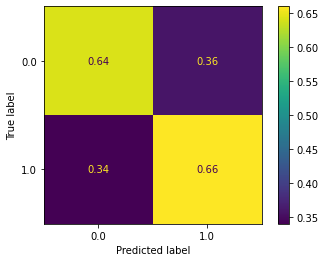

In [122]:
plot_confusion_matrix(optimal_logit_balanced, X_test_reduced, y_test_reduced, normalize='true')

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


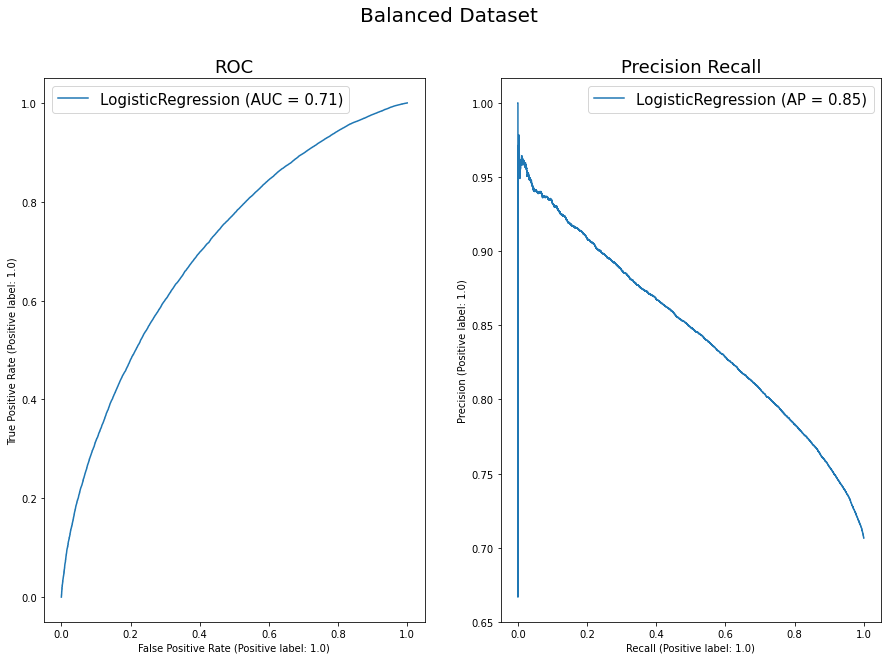

[CV 2/3; 1/5] START C=0.1.......................................................
[CV 2/3; 1/5] END ........................C=0.1;, score=0.724 total time= 1.9min
[CV 2/3; 4/5] START C=2.........................................................
[CV 2/3; 4/5] END ..........................C=2;, score=0.652 total time= 3.4min
[CV 1/3; 1/5] START C=0.1.......................................................
[CV 1/3; 1/5] END ........................C=0.1;, score=0.724 total time= 1.9min
[CV 1/3; 2/5] START C=0.5.......................................................
[CV 1/3; 2/5] END ........................C=0.5;, score=0.651 total time= 3.8min
[CV 1/3; 3/5] START C=1.........................................................
[CV 1/3; 3/5] END ..........................C=1;, score=0.724 total time= 1.8min
[CV 3/3; 1/5] START C=0.1.......................................................
[CV 3/3; 1/5] END ........................C=0.1;, score=0.653 total time= 3.9min
[CV 3/3; 2/5] START C=0.5...

In [123]:
plot_roc_precision(optimal_logit_balanced,  X_test_reduced, y_test_reduced)

Note that the ROC and precission recall curves indicate that oversampoling the dataset does not improve the performance of the model with the original dataset.

## Logistic with SMOTE oversampling

It is worth mentioning that we did run smote with 50% of the original dataset not obtaining significative improvement. In fact, the score with 50% of the total dataset was 48%. As we shall see in this section using 100% of the data implies a score of 84%, a significant improvement with respect imbalanced logisitic and oversampled logistic.

In [8]:
C = [1/10, 1/2, 1, 2, 5, 10]
pipeline = imbpipeline(steps = [('smote', SMOTE(random_state=random_state)), ('scaler', MinMaxScaler()),
                                ('classifier', LogisticRegression(penalty="l1",solver="liblinear",max_iter=int(1e6),warm_start=True))])
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
param_grid = {'smote__k_neighbors': [1, 3, 4, 5, 10],
              "classifier__C":C
             }
grid_search = GridSearchCV(estimator=pipeline,
                            param_grid=param_grid,
                            scoring='average_precision',
                            cv=cv,
                            verbose=True,
                            n_jobs=-1)
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Cross-validation score: 0.8447719453884158
Test score: 0.8455199394855287


In [9]:
# Retreive best model 
optimal_logit_smote = grid_search.best_estimator_["classifier"]

In [12]:
# Retreive best params 
grid_search.best_params_

{'classifier__C': 0.1, 'smote__k_neighbors': 1}

### Scale test data for performance

In [13]:
scaler = grid_search.best_estimator_["scaler"]
X_test_scaled = X_test
X_test_scaled[X_test_scaled.columns] = scaler.fit_transform(X_test[X_test.columns])
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1, 1))


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


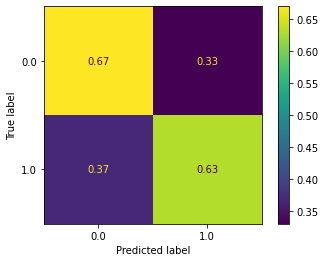

In [14]:
plot_confusion_matrix(optimal_logit_smote, X_test_scaled, y_test_scaled, normalize='true')

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.p

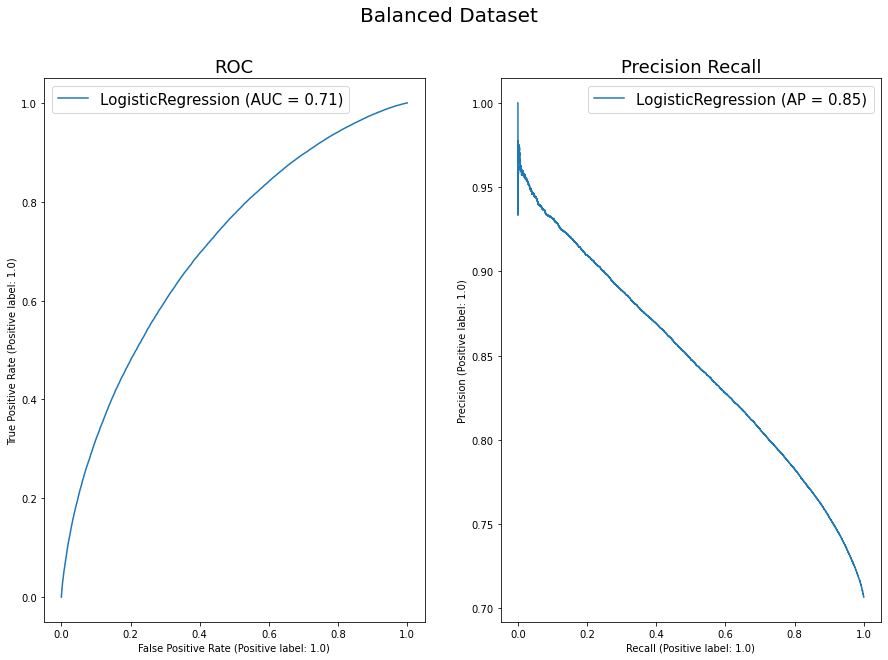

In [15]:
plot_roc_precision(optimal_logit_smote,   X_test_scaled, y_test_scaled)

## Variable selection from Logistic model with SMOTE oversampling

### Logistic coefficients

In [19]:
list_tuples = list(zip(variables, np.round(optimal_logit_smote.coef_[0], 1)))
coef_df = pd.DataFrame(list_tuples, columns =['Predictor', 'Logistic COEF'])
coef_df

,Predictor,Logistic COEF
0,loan_amnt,-0.3
1,term,-0.6
2,sub_grade,-2.8
3,installment,-0.6
4,issue_d,0.0
5,annual_inc,0.4
6,emp_length,0.1
7,verification_status,-0.1
8,purpose,-0.1
9,home_ownership,-0.3


### Omitted predictors by Logistic model

Note that we are using l1 norm as penalty in the logistic model. Therefore, coefficient shrinkage is performed, alloging variable selection.

In [20]:
# Omitted
coef_df[coef_df['Logistic COEF'] == 0]

,Predictor,Logistic COEF
4,issue_d,0.0
15,earliest_cr_line,-0.0
25,num_tl_90g_dpd_24m,0.0
26,percent_bc_gt_75,-0.0
31,tax_liens,0.0
39,verification_status_joint,0.0


### Selected predictors by Logistic model

In [21]:
# Selected
coef_df[coef_df['Logistic COEF'] != 0]

,Predictor,Logistic COEF
0,loan_amnt,-0.3
1,term,-0.6
2,sub_grade,-2.8
3,installment,-0.6
5,annual_inc,0.4
6,emp_length,0.1
7,verification_status,-0.1
8,purpose,-0.1
9,home_ownership,-0.3
10,addr_state,0.1


# Random forest

This is the final part of our model. After eliminating the non-significant variables indicated by Logit model with SMOTE oversampling, we will fit a random forest model to get the final results.

We aslo must note that we will use the original data set and the orginal train and test sets.

### Delete penalized variables by Logit model

In [22]:
X_train_mod = X_train.copy()
X_test_mod = X_test.copy()
X_train_mod = X_train_mod.drop(["tax_liens", 
                                "verification_status_joint", 
                                "issue_d",
                                "num_tl_90g_dpd_24m",
                                "percent_bc_gt_75"
                               ], axis=1)
X_test_mod = X_test_mod.drop(["tax_liens", 
                                "verification_status_joint", 
                                "issue_d",
                                "num_tl_90g_dpd_24m",
                                "percent_bc_gt_75"
                               ], axis=1)

#### Find optimal hyperparameters

In [155]:
# Parameter optimisation
n_estimators = [200, 500, 1000]
max_features = ['sqrt', 0.5]
max_depth = [20, 50, 100]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
rfc = RandomForestClassifier(random_state=random_state, n_jobs=-1)
n_iter = 10  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
cv = 3  # Cross-validation folds
rf_random = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=n_iter, cv=cv,
                               random_state=random_state, n_jobs=-1, scoring='average_precision')

rf_random.fit(X_train_scaled, smote_y)
best_parameters = rf_random.best_params_
print('The best Parameters are:')
for key, item in best_parameters.items():
    print(f'- {key}: {item}')

In [23]:
rfc_opt = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features = 'sqrt',
                                 max_depth=100, random_state=random_state, n_jobs=-1)
rfc_opt.fit(X_train_mod, y_train)
rfc_opt.score(X_test_mod,y_test)

0.7066071493114541